In [1]:
%matplotlib inline
import astropy.units as u
from astropy.constants import G, k_B, m_p
import matplotlib.pylab as plt
import numpy as np

In [2]:
m_star = 0.013 # Solar masses

For a given planetesimal surface density profile, temperature profile and gas-to-dust ratio profile, determine if the disk is Toomre-stable

In [3]:
# Toomre q parameter
def toom_q(cs, omega, sigma):
    return cs*omega/(np.pi*G.cgs*sigma)

# Planetesimal surface density profile, r in AU
def sigma_pl(alpha, A, r, f):
    return f*A*r**(-alpha)

# Orbital period to semimajor axis
def sma(t_orb):
    return (G.cgs.value*(m_star*u.M_sun).to(u.g).value*(t_orb/(2*np.pi))**2)**(1/3)

# Temperature profile of disk, r in AU
def T_prof(T0, q, r):
    return T0*r**(-q)

# Headwind velocity of gas in pressure-supported disk
# r and m_central in cm and M_sun, cs in cm/s
# q is the power law index of the pressure profile, which should be same as
# temperature profile for an ideal gas
def v_phi_gas(m_central, r, cs, q):
    m_central_cgs = (m_central*u.M_sun).to(u.g).value
    v_k = np.sqrt(G.cgs.value*m_central_cgs/r)
    return v_k*(1 - np.sqrt(1 - (q*cs**2/v_k**2)))

# Stopping time of planetesimal in stokes regime
def t_stop(m_pl, s_pl, C_D, rho_gas, v_gas):
    return 2*m_pl/(C_D*np.pi*s_pl**2*rho_gas*v_gas)

# Radial drift velocity of planetesimal in stokes regime (Weidenschilling 1997)
def vr_drift(m_pl, s_pl, C_D, rho_gas, v_gas, omega):
    ts = t_stop(m_pl, s_pl, C_D, rho_gas, v_gas)
    return 2*v_gas/(omega*ts + 1/(omega*ts))

# Viscous stirring timescale of planetesimals (Ida 1993 eq 4.2)
def t_vs_I93(m_pl, omega, r, sigma_pl, e_disp):
    return 1/40*(omega**2*r**3/(2*G.cgs.value*m_pl))**2*(4*m_pl*e_disp**2/(sigma_pl*r**2*omega))

# Relaxation time, equal to viscous stirring timescale in dispersion dominated regime
def t_relax(v, n, m):
    logLam = 3 # Is this true at short period?
    return v**3/(np.pi*G.cgs.value**2*n*m**2*logLam)

# Equilibirum eccentricity of planetesimals in gas
# Derived by equating viscous stirring timescale (Ida 1993 eq 4.2)
# With the stopping time (Adachi 1976)
def e_eq_I93(sigma_pl, m_pl, s_pl, omega, C_D, rho_gas, v_gas):
    t_s = t_stop(m_pl, s_pl, C_D, rho_gas, v_gas)
    return (40*(2*G.cgs.value*m_pl/(omega**2*r**3))**2*t_s*(sigma_pl*r**2*omega/(4*m_pl)))**(1/4)
    
# Equilibirum eccentricity of planetesimals in gas
# Derived by equating relaxation time (Ida 1993)
# With the stopping time (Adachi 1976)
def e_eq(omega, sigma_pl, m_pl, s_pl, C_D, vk, rho_gas, v_gas):
    logLam = 3
    return (G.cgs.value**2*m_pl**2*logLam*omega*sigma_pl/(C_D*s_pl**2*vk**4*rho_gas*v_gas))**(1/4)
    
# Equilibirum eccentricty of planetesimals in gas
# Equation 12 from kokubo + ida 2002
#def e_eq(m_p, rho_p, rho_gas, b_p, C_D, r):
#    return 5.6*(m_p/1e23)**(1/15)*(rho_p/2)**(2/15)*(b_p/10)**(-1/5)*\
#           (C_D/1)**(-1/5)*(rho_gas/2e-9)**(-1/5)*(r/1)**(-1/5)

gas_to_dust = 1/240 # Hayashi 1981

In [4]:
t_in, t_out = 1, 100 # Days
r_in, r_out = sma((t_in*u.d).to(u.s).value), sma((t_out*u.d).to(u.s).value)
r = np.linspace(r_in, r_out)
r_AU = (r*u.cm).to(u.AU).value

In [5]:
# Hayashi 1981, scaled by mass of star
alpha = 3/2
A = 6
f = m_star
surf_den = sigma_pl(alpha, A, r_AU, f)
surf_den_gas = surf_den/gas_to_dust

Text(0, 0.5, 'Surface Density [g cm$^{-2}$]')

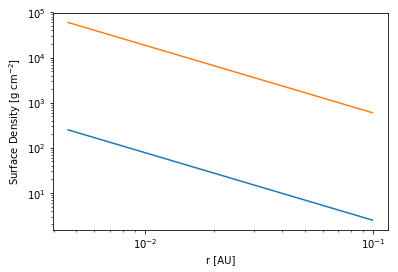

In [6]:
plt.plot(r_AU, surf_den)
plt.plot(r_AU, surf_den_gas)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel(r'Surface Density [g cm$^{-2}$]')

Text(0, 0.5, 'Temperature [K]')

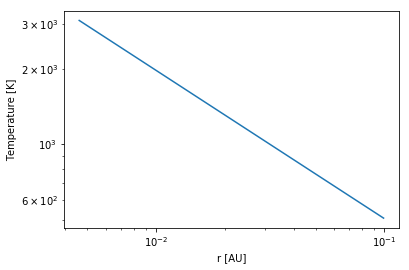

In [7]:
# Values for M stars from Backus + Quinn 2016
q = 0.59
T0 = 130

T = T_prof(T0, q, r_AU)
plt.plot(r_AU, T)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel('Temperature [K]')

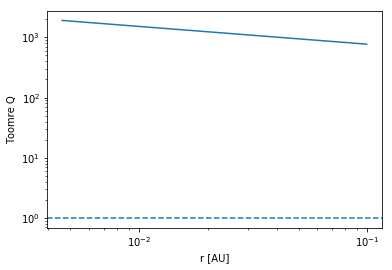

In [8]:
mu = 2.34 # Hayashi 1981
cs = np.sqrt(k_B.cgs.value*T/(mu*m_p.cgs.value))
omega = np.sqrt(G.cgs.value*(m_star*u.M_sun).to(u.g).value/r**3)
#cs = 0.05*omega*r
toom = toom_q(cs, omega, surf_den+surf_den_gas)

plt.plot(r_AU, toom)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel('Toomre Q')
plt.axhline(1, ls='--')

Text(0, 0.5, 'Midplane Gas Density [g cm$^{-3}$]')

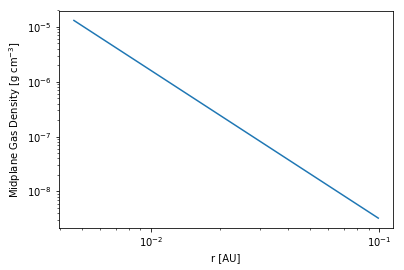

In [9]:
h_gas = cs/omega
rho_gas = surf_den_gas/h_gas
plt.plot(r_AU, rho_gas)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel(r'Midplane Gas Density [g cm$^{-3}$]')

Text(0, 0.5, 'Headwind Velocity of Gas [cm s$^{-1}$]')

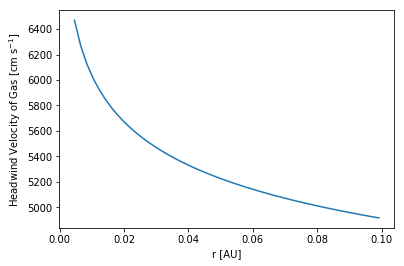

In [10]:
v_gas = v_phi_gas(m_star, r, cs, q)
plt.plot(r_AU, v_gas)
plt.xlabel('r [AU]')
plt.ylabel(r'Headwind Velocity of Gas [cm s$^{-1}$]')

In [11]:
rho_pl = 2
s_pl = (100*u.km).to(u.cm).value
m_pl = 4/3*np.pi*s_pl**3*rho_pl
print(m_pl)

C_D = 1

8.377580409572781e+21


In [12]:
vk = np.sqrt(G.cgs.value*(m_star*u.M_sun).to(u.g).value/r)
# Eccentricity at which velocity dispersion equals sound speed
e_max = np.sqrt(4/5)*cs/vk
e_max_hill = e_max/(m_pl/(3*m_star*u.M_sun).to(u.g).value)**(1/3)

In [13]:
# Equilibirum eccentricity of planetesimals in gas
# Derived by equating relaxation time (Ida 1993)
# With the stopping time (Adachi 1976)
def e_eq(omega, sigma_pl, m_pl, s_pl, C_D, vk, rho_gas, v_gas):
    logLam = 3
    return (G.cgs.value**2*m_pl**2*logLam*omega*sigma_pl/(C_D*s_pl**2*vk**4*rho_gas*v_gas))**(1/4)

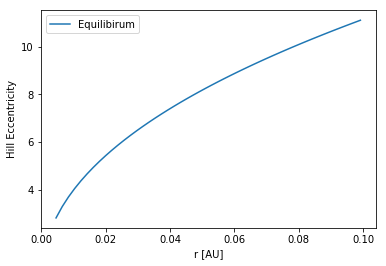

In [14]:
eeq = e_eq(omega, surf_den, m_pl, s_pl, C_D, vk, rho_gas, v_gas)
eeq_hill = eeq/(m_pl/(3*m_star*u.M_sun).to(u.g).value)**(1/3)
plt.plot(r_AU, eeq_hill, label='Equilibirum')
#plt.plot(r_AU, e_max_hill, label='Max')
plt.xlabel('r [AU]')
plt.ylabel(r'Hill Eccentricity')
plt.legend()

In [15]:
# Need gas drag and viscous stirring timescale to be short relative to other relevant timescales
v = vk*eeq
h_pl = v/omega
n_pl = surf_den/(2*m_pl*h_pl)
trel = t_relax(v, n_pl, m_pl)
tstop = t_stop(m_pl, s_pl, C_D, rho_gas, v_gas)

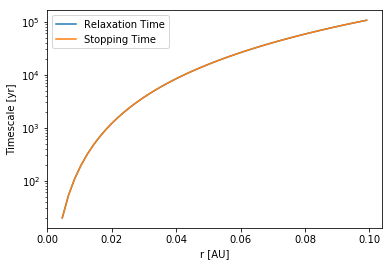

In [18]:
plt.plot(r_AU, trel/3.15e7, label='Relaxation Time')
plt.plot(r_AU, tstop/3.15e7, label='Stopping Time')
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel('Timescale [yr]')
plt.legend()

Text(0, 0.5, 'Radial Drift Timescale [yr]')

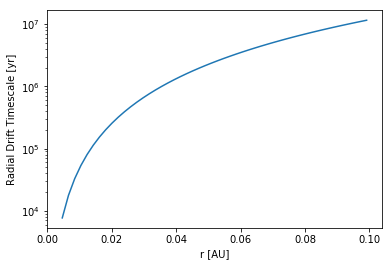

In [17]:
vr = vr_drift(m_pl, s_pl, C_D, rho_gas, v_gas, omega)
t_drift = r/vr
plt.plot(r_AU, t_drift/3.15e7)
plt.yscale('log')
plt.xlabel('r [AU]')
plt.ylabel('Radial Drift Timescale [yr]')